# Survival Analysis of Ovarian Cancer: PODXL, RAC2, and Tumor Stage

Through modern statistical methods, we can determine survival risk based on a variety of factors.  In this tutorial, we will walk through a small example of something you could do with our data to understand what factors relate with survival in various different types of cancer.  In this use case, we will be looking at Ovarian Cancer

## Step 1: Import Data and Dependencies

In [1]:
import pandas as pd
import cptac
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import lifelines
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
%matplotlib inline

In [2]:
ov = cptac.Ovarian()
clinical = ov.get_clinical()
proteomics = ov.get_proteomics()
follow_up = ov.get_followup()

## Step 2: Data Preparation
We will be focusing on the discovery cohort of tumors, for which we have follow-up data. We will first merge the clinical and follow-up tables together for analysis. Then we will choose a few attributes to focus on, and narrow our dataframe to those attributes. While you could study a wide variety of factors related to survival, such as country of origin or number of full pregnancies, we will be focusing on tumor stage and grade.

In [3]:
#Determine columns to focus on, and create a subset to work with
follow_up = follow_up.rename({'PPID' : 'Patient_ID'}, axis='columns')

cols = list(clinical.columns)
omics_genes = ['RAC2', 'PODXL', 'GBP2', 'GBP5']

clinical_and_protein = ov.join_metadata_to_omics(metadata_df_name="clinical", 
                                                 omics_df_name="proteomics", 
                                                 metadata_cols=cols, 
                                                 omics_genes=omics_genes)

clinical_and_protein = ov.reduce_multiindex(clinical_and_protein, 
                                            levels_to_drop="Database_ID")

focus_group = pd.merge(clinical_and_protein, follow_up, on = "Patient_ID")

columns_to_focus_on = ['Vital_Status',
                       'Days_Between_Collection_And_Last_Contact', 
                       'Days_Between_Collection_And_Death',
                       'Tumor_Stage_Ovary_FIGO']

for i in range(len(omics_genes)):
    omics_genes[i] += '_proteomics'
    columns_to_focus_on.append(omics_genes[i])

focus_group = focus_group[columns_to_focus_on].copy().drop_duplicates()

cptac warning: proteomics data was not found for the following samples, so proteomics data columns were filled with NaN for these samples: 01OV002, 01OV008, 01OV010, 01OV013, 01OV019, 01OV024, 01OV033, 01OV045, 01OV046, 01OV049, 02OV001, 02OV035, 02OV040, 02OV042, 02OV045, 04OV041, 11OV009, 11OV010, 13OV004, 14OV029, 17OV003, 17OV004, 17OV005, 17OV006, 17OV007, 17OV012, 17OV016, 17OV019, 17OV022, 17OV026, 17OV031, 17OV034, 17OV035, 17OV037, 17OV038, 22OV001, 26OV010 (C:\Users\Daniel\AppData\Local\conda\conda\envs\Research\lib\site-packages\ipykernel_launcher.py, line 10)


## Step 2b: Prepare data for Kaplan Meier Plotting
We will start by finding all patients that have died during the follow-up period and update the column to contain boolean values, where True denotes that the event occurred ('Deceased'), and False denotes that it did not ('Living').  This is necessary to fit the requirements of the *lifelines* package.

In [4]:
#Make the Vital Status column boolean
focus_group['Vital_Status'] = focus_group['Vital_Status'].replace('Living', False)
focus_group['Vital_Status'] = focus_group['Vital_Status'].replace('Deceased', True)

In [5]:
figo_map = {"IIIC" : 3, "IIIB" : 3, 
            "Not Reported/ Unknown" : np.nan, 
            "IIIA" : 3, "III" : 3, 
            "IC" : 1, "IV" : 4}
focus_group['Tumor_Stage_Ovary_FIGO'] = focus_group['Tumor_Stage_Ovary_FIGO'].map(figo_map)

In [6]:
cols = ['Days_Between_Collection_And_Last_Contact', 'Days_Between_Collection_And_Death']

focus_group = focus_group.assign(Days_Until_Last_Contact_Or_Death=focus_group[cols].sum(1)).drop(cols, 1)

In [7]:
focus_group = focus_group.dropna().copy()

In [8]:
df_clean = focus_group.dropna(axis=0, how='any')
deceased = df_clean[df_clean["Vital_Status"] == True]
living = df_clean[df_clean["Vital_Status"] == False]
#living
for gene in omics_genes:
    print(gene)
    print(scipy.stats.ttest_ind(deceased[gene], living[gene]), '\n')

RAC2_proteomics
Ttest_indResult(statistic=-1.2356270986126083, pvalue=0.22055884091461977) 

PODXL_proteomics
Ttest_indResult(statistic=-0.48073126593165366, pvalue=0.6321451612987006) 

GBP2_proteomics
Ttest_indResult(statistic=-0.9948956713462044, pvalue=0.32307343280383083) 

GBP5_proteomics
Ttest_indResult(statistic=-0.4448552227776217, pvalue=0.6577406181586254) 



In [9]:
df_genes = df_clean.copy()
for col in omics_genes:
    lower_25_filter = df_genes[col] <= df_genes[col].quantile(.25)
    upper_25_filter = df_genes[col] >= df_genes[col].quantile(.75)

    df_genes[col] = np.where(lower_25_filter, "Lower_25%", df_genes[col])
    df_genes[col] = np.where(upper_25_filter, "Upper_25%", df_genes[col])
    df_genes[col] = np.where(~lower_25_filter & ~upper_25_filter, "Middle_50%", df_genes[col])

In [10]:
proteomics_map = {"Lower_25%" : 1, "Middle_50%" : 2, "Upper_25%" : 3}
for gene in omics_genes:
    df_genes[gene] = df_genes[gene].map(proteomics_map)
    
focus_group = df_genes.copy()

In [11]:
focus_group['Vital_Status'] = focus_group['Vital_Status'].astype(bool)

Next, we will subset the data to just the attributes we are testing for survival (numeric values), an event-of-interest column ('Vital Status'; boolean) and a column with a numeric time frame ('Path Diag to Last Contact(Day)'; numeric). This format is necessary for creating Kaplan Meier plots and running survival analysis, so be sure that your data is in this format.

In [12]:
focus_group.head()

Name,Vital_Status,Tumor_Stage_Ovary_FIGO,RAC2_proteomics,PODXL_proteomics,GBP2_proteomics,GBP5_proteomics,Days_Until_Last_Contact_Or_Death
Patient_ID,,,,,,,
01OV007,False,4.0,2,3,2,2,368.0
01OV017,False,3.0,1,1,2,2,395.0
01OV018,False,3.0,2,2,2,2,390.0
01OV023,False,3.0,2,1,3,3,375.0
01OV026,True,3.0,2,2,3,3,112.0


Verify that your columns are the correct data types.  They may appear to be correct up front, but could actually be hidden as slightly different data types. The event of interest, in this case *Vital_Status* needs to contain boolean values, and all other columns in the table must be a numeric type (either int64 or float64).

In [13]:
for col in focus_group.columns:
    print(col, ":", focus_group[col].dtype)

Vital_Status : bool
Tumor_Stage_Ovary_FIGO : float64
RAC2_proteomics : int64
PODXL_proteomics : int64
GBP2_proteomics : int64
GBP5_proteomics : int64
Days_Until_Last_Contact_Or_Death : float64


# Step 3: Kaplan-Meier Plots
Kaplan Meier plots show us the probability of some event occuring over a given length of time, based on some attribute(s).  Oftentimes, they are used to plot the probability of death for clinical attributes, however they could also be used in a variety of other contexts.

Here, we show a general Kaplan Meier Plot of survival overall for our cohort, using the KaplanMeierFitter() from the lifelines package.

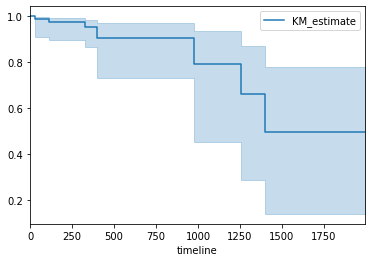

In [14]:
time = focus_group['Days_Until_Last_Contact_Or_Death']
status = focus_group['Vital_Status']

kmf = KaplanMeierFitter()
kmf.fit(time, event_observed = status)
kmf.plot()

# Step 4: Format data for Cox's Proportional Hazard test

With the CoxPHFitter from the lifelines package we can see covariate survival plots, as shown below.  The variables we are interested in exploring are Tumor Stage, RAC2, and PODXL protein abundance.

First we will fit our model to the data we have prepared using the CoxPHFitter() class from the lifelines module.

In [15]:
cph = CoxPHFitter()
cph.fit(focus_group, duration_col = "Days_Until_Last_Contact_Or_Death", 
        event_col = "Vital_Status")

<lifelines.CoxPHFitter: fitted with 75 total observations, 68 right-censored observations>

Then we will plot each of the attributes to see how different levels of protein or different tumor stages affect survival outcomes in Ovarian Cancer patients.

In [16]:
attributes = omics_genes.copy()

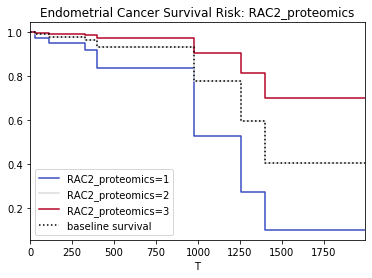

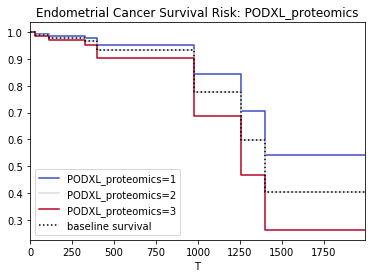

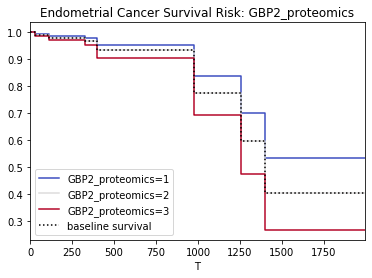

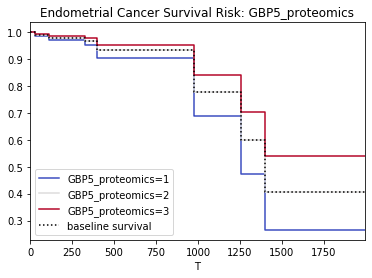

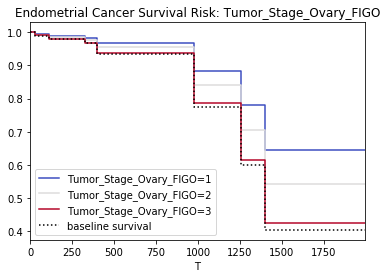

In [17]:
attributes.append('Tumor_Stage_Ovary_FIGO')

for attribute in attributes:
    cph.plot_covariate_groups(attribute, [1,2,3], cmap='coolwarm', 
                          title= "Endometrial Cancer Survival Risk: " + attribute)

# Results
These different analyses tend to follow the baseline survival function, however, there are some differences in varying levels of each attribute. For example, FIGO Stage I tumors tend to have a higher survival rate over time comparatively to Stage III tumors.  We can explore these differences with the CoxPHFitter object's *print_summary* function (which prints out results for multivariate linear regression) and with the *proportional_hazard_test* (which performs Cox's Proportional Hazard Test on the data to determine how each attribute contributes to our cohort's overall survival).

In [18]:
cph.print_summary(model="untransformed variables", decimals=3)

<lifelines.CoxPHFitter: fitted with 75 total observations, 68 right-censored observations>
      duration col = 'Days_Until_Last_Contact_Or_Death'
         event col = 'Vital_Status'
number of observations = 75.0
number of events observed = 7.0
partial log-likelihood = -19.606
  time fit was run = 2020-02-28 00:06:43 UTC
             model = untransformed variables


---
                         coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
Name                                                                                                                     
Tumor_Stage_Ovary_FIGO  0.333     1.395     0.788          -1.211           1.877               0.298               6.534
RAC2_proteomics        -0.927     0.396     0.813          -2.521           0.667               0.080               1.949
PODXL_proteomics        0.391     1.479     0.569          -0.723           1.506               0.485               4.508
GBP2_proteomics 

In [19]:
results = proportional_hazard_test(cph, focus_group, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
                        test_statistic     p  -log2(p)
GBP2_proteomics                  1.593 0.207     2.273
GBP5_proteomics                  3.149 0.076     3.718
PODXL_proteomics                 5.019 0.025     5.318
RAC2_proteomics                  1.603 0.205     2.283
Tumor_Stage_Ovary_FIGO           0.712 0.399     1.326


The hazard ratios for Histologic Grade and Tumor Stage are located in the column labeled "-log2(p)" above. If a ratio is greater than 1, the hazard is greater than would be expected, suggesting that the feature associated with it has a higher likelihood of the negative event occurring than would normally be expected.  Likewise, if the ratio is less than 1, the opposite is true.  A ratio of 1 would be considered normal.

Below, we show confidence intervals for each of the two hazard ratios.  Since both bars include the log(HR) of 1.0 and both of their p-values were greater than 0.05, there is insufficient evidence to suggest that a specific Histologic Grade or Tumor Stage is connected with negative clinical outcomes of death or the development of a new tumor *in our cohort of Ovarian cancer tumors*.

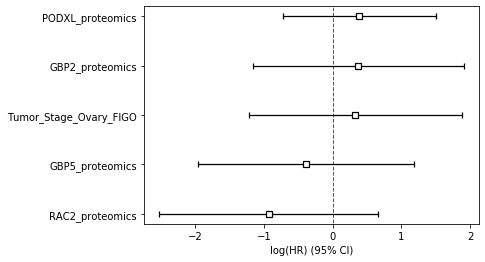

In [20]:
cph.plot()

In [21]:
focus_group['Vital_Status'].value_counts()

False    68
True      7
Name: Vital_Status, dtype: int64

 It is important to note that there are relatively few patients who had negative outcomes (7 out of 68), which is good, but with such a small sample size, it is difficult to conclude with certainty that these features are not more connected with negative outcomes.  Perhaps a sample of patients with more negative outcomes might have different results.  Alternatively, studying an event with more negative outcomes (such as tumor recurrence) may also provide more data to work with.

It is also important to recognize that the confidence intervals for these ratios are very large, especially since hazard ratios are on a log-scale.

In [22]:
cph.confidence_intervals_

,95% lower-bound,95% upper-bound
Name,,
Tumor_Stage_Ovary_FIGO,-1.211240,1.877080
RAC2_proteomics,-2.521446,0.667299
PODXL_proteomics,-0.723425,1.505798
GBP2_proteomics,-1.158771,1.905068
GBP5_proteomics,-1.956752,1.189371


This is just one example of how you might use Survival Analysis to learn more about different types of cancer, and how clinical and/or genetic attributes contribute to likelihood of survival. There are many other clinical and genetic attributes, as well as several other cancer types, that can be explored using a similar process to that above. In particular, lung cancer and ovarian cancer have a larger number of negative outcomes per cohort, and would be good to look into further. 